1. Import Packages

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf

import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score, classification_report, plot_confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.naive_bayes import MultinomialNB

import matplotlib.pyplot as plt

from tabulate import tabulate

from langdetect import detect

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vineelgannu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vineelgannu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/vineelgannu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


2. Data Selection

In [2]:
# Data
data = pd.read_csv('reviews_by_course.csv', names=["courseid", "review", "label"], header=0, dtype={'label':'str'})

print(data.head())

     courseid                                             review label
0  2-speed-it                                             BOring     1
1  2-speed-it                                             Bravo!     5
2  2-speed-it                                          Very good     5
3  2-speed-it  Great course - I recommend it for all, especia...     5
4  2-speed-it    One of the most useful course on IT Management!     5


3. Exploratory Data Analysis

In [3]:
# Describe the data   
print('\n Total number of data objects:             ', len(data))
print('\n Total number of attributes:                    ', len(data.columns))
print('\n Total number of values:                   ', len(data)*len(data.columns))
print('\n Total number of duplicates data objects:    ', len(data)-len(data.drop_duplicates()))
print('\n Total number of missing values:                ', data.isnull().sum().sum())
data.describe()


 Total number of data objects:              140320

 Total number of attributes:                     3

 Total number of values:                    420960

 Total number of duplicates data objects:     3016

 Total number of missing values:                 3


,courseid,review,label
count,140320,140317,140320
unique,1835,123233,5
top,machine-learning,Great course!,5
freq,8570,509,106516


4. Data Cleaning

In [4]:
# Remove Duplicate Records
data.drop_duplicates(inplace=True)

# Remove records with missing values
data = data.dropna()

# Remove records with numeric values
data = data.drop(data[data['review'].str.isnumeric()].index) 

# Resets the index in the dataframe
data = data.reset_index(drop=True)

5. Data Preprocessing

In [5]:
# Function to preprocess the reviews in the data
def preprocess_data(review_data):
    ps = PorterStemmer()
    
    preprocessed_review = []
    preprocessed_label = []
    
    for i in range(1, len(review_data)):
        # Remove Noisy Data
        review = re.sub('[^a-zA-Z\\s]', '', review_data[i]).strip()

        # Remove Non-english Reviews
        if(len(review) == 0 or len(review) == 1 or detect(review) == "vi" or  detect(review) == "ko" or detect(review) == "ru" or detect(review) == "zh-cn"):
            continue
        
        # Lower all the characters
        review = review.lower() if review.lower() != "" else ""
         
        # Tokenization
        words= nltk.word_tokenize(review)
        
        # Stopwords are ignored and non-stopwords are stemmed
        words = [ps.stem(word) for word in words if word not in set(stopwords.words('english'))]
        
        review_data[i] = ' '.join(words)
        
        # Eliminate if the reviews are blank after preprocessing
        if(review_data[i] !=""):
            preprocessed_review.append(review_data[i]);
            preprocessed_label.append(data['label'][i]);
        
    return preprocessed_review, preprocessed_label

In [6]:
X_transformed, y = preprocess_data(data['review'].values)

6. Data Splitting

In [7]:
# The entire dataset is split into training and test datasets with 80% of training dataset and 20% of test dataset
X_train_naivebayes, X_test_naivebayes, y_train_label, y_test_label = train_test_split(X_transformed, y, test_size = 0.20, random_state = 10)

7. Data Transformation

In [8]:
# Tokenizer is used to vectorize the reviews where the reviews are converted to sequence of integers
tokenizer = Tokenizer(num_words=500)
total_reviews = X_train_naivebayes + X_test_naivebayes

# Updates internal vocabulary based on a list of reviews.
tokenizer.fit_on_texts(total_reviews) 

# The reviews are converted to word count matrix
X_train_naivebayes_matrix =  tokenizer.texts_to_matrix(X_train_naivebayes, mode='count')
X_test_naivebayes_matrix = tokenizer.texts_to_matrix(X_test_naivebayes, mode='count')

8. Model Training

In [9]:
# naive_bayes function performs Naive Bayes classification
def naive_bayes():
    model_train_naivebayes = MultinomialNB().fit(X_train_naivebayes_matrix, y_train_label)
    return model_train_naivebayes, model_train_naivebayes.predict(X_test_naivebayes_matrix)

In [10]:
nbclassifier, y_pred_naivebayes = naive_bayes()

9. Model Evaluation

Performance Metrics      Values
---------------------  --------
Accuracy               0.763599
Precision              0.720513
Recall                 0.763599
F1score                0.732644

 Naive Bayes Classification Report 
               precision    recall  f1-score   support

           1      0.347     0.305     0.324       545
           2      0.244     0.153     0.188       498
           3      0.255     0.195     0.221      1104
           4      0.443     0.218     0.292      4338
           5      0.829     0.941     0.881     19987

    accuracy                          0.764     26472
   macro avg      0.423     0.362     0.381     26472
weighted avg      0.721     0.764     0.733     26472

Normalized Naive Bayes Confusion Matrix


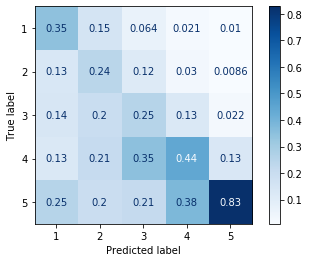

In [11]:
# Metrics such as accuracy, precision, recall and F1score are used to evaluate the Naive Bayes Classification

accuracy = accuracy_score(y_test_label, y_pred_naivebayes)

precision, recall, F1score, support = precision_recall_fscore_support(y_test_label, y_pred_naivebayes, average='weighted')

header=['Precision', 'Recall','F1Score', 'Support']

print(tabulate([['Accuracy', accuracy], ['Precision', precision], ['Recall', recall], ['F1score', F1score]], headers=['Performance Metrics', 'Values']))

print('\n Naive Bayes Classification Report \n', classification_report(y_test_label, y_pred_naivebayes, digits=3))

plot_confusion_matrix(nbclassifier, X_test_naivebayes_matrix, y_test_label, normalize='pred', cmap=plt.cm.Blues)

print('Normalized Naive Bayes Confusion Matrix')